# Hough transform in 3D 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from itertools import product
from typing import Tuple, List

## Generate weird data

In [2]:
x = np.random.uniform(low=-500, high=500, size=100)
y = np.random.uniform(low=-500, high=500, size=100)
z = np.random.uniform(low=-500, high=500, size=100)

points = np.array(list(zip(x, y, z)))

### Show the points

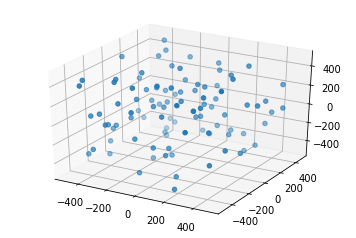

In [3]:
point_cloud = plt.axes(projection='3d')
point_cloud.scatter3D(x, y, z)

## Implementation of the Hough transform in 3D

### Algorithm

In [4]:
class GeoTransformations:
    """
    Helpful analytical operations in
    cartesian and spherical coordinates
    """
    
    def spherical_coord_to_cartesian_coord(self,
                                           point: np.array) -> np.array:
        """
        Convert a point in spherical coordinates
        to a point in euclid coordinates
        """
        
        r, theta_1, theta_2 = point
        
        # Cartesian coordinates
        x = np.sin(theta_1) * np.cos(theta_2)
        y = np.sin(theta_1) * np.sin(theta_2)
        z = np.cos(theta_1)
        
        return r * np.array([x, y, z])
    
    def euclid_point_to_plane(self, point: np.ndarray,
                                plane: np.ndarray) -> float:
        """
        Calculate euclid dist between a point
        and a plane, both in euclid coordinates
        
        plane: np.array([a, b, c, d]) such that
        ax + by + cz + d = 0
        
        point: np.array([x, y, z])
        """
        
        numerator = abs(np.sum(np.multiply(plane[:-1], point)) + plane[-1])
        denominator = np.sqrt(np.sum(plane[:-1]**2))
        
        return numerator / denominator
    
    def max_dist_point(self, points: np.ndarray) -> float:
        """
        Find the point with the maximum distance
        from the origin
        """
        
        distances = np.array([np.sqrt(np.sum(point**2))
                              for point in points])
        
        return np.max(distances)

In [5]:
class Hough3D(GeoTransformations):
    
    def __init__(self, point_cloud: np.ndarray, dist_to_plane: float = 5.,
                 threshold: int = 10, r_diff: float = 5.,
                 theta_1: float = np.pi / 10, theta_2: float = np.pi / 10):
        super().__init__()
        self.points = point_cloud
        self.dist = dist_to_plane
        self.threshold = threshold
        self.r_diff = r_diff
        self.theta_1 = theta_1
        self.theta_2 = theta_2
        
        # Limit the searching to a sphere
        self.r_of_space = self.max_dist_point(points)
        
    def all_possible_planes(self) -> np.ndarray:
        """
        Find all possible planes, each coresponding
        to the unique (r, theta1, theta2) tuple
        """
        
        # All possible planes
        r_coord = np.arange(-self.r_of_space, self.r_of_space + self.r_diff,
                            self.r_diff)
        theta_1_coord = np.arange(0., 2*np.pi + self.theta_1, self.theta_1)
        theta_2_coord = np.arange(0., 2*np.pi + self.theta_2, self.theta_2)
        planes = np.array(list(product(r_coord, theta_1_coord, theta_2_coord)))
        
        return planes
    
    def planes_in_cartesian_normal_form(self, planes: np.array) -> np.array:
        """
        Transform points in spherical coordinates
        to quadruples (A, B, C, D), each coresponding
        to a unique plane
        """
        
        cart_planes = []
        
        for spher_coord in planes:
            cart_coord = self.spherical_coord_to_cartesian_coord(spher_coord)
            
            # Knowing that the normal vec to plane begins at O,
            # the plane formula is A(x - A) + B(y - B) + C(z - C) = 0
            d = -np.sum(cart_coord**2)
            
            cart_planes.append(np.hstack((cart_coord, d)))
            
        return np.array(cart_planes)
    
    def voting_phase(self, cart_planes: np.array) -> List:
        """
        Create an array of votes for each plane
        in the cartesian normal form
        """
        
        votes = [[point for point in self.points 
                  if self.euclid_point_to_plane(point, plane) <= self.dist]
                 for plane in cart_planes]

        return tuple(zip(cart_planes, votes))
        
    def estimation_phase(self, votes: np.array) -> Tuple:
        """ Filter the planes exceeding the threshold """
        
        # Filter the planes
        found_planes = tuple(filter(
            lambda pl_votes: len(pl_votes[1]) >= self.threshold, votes
        ))
        
        return found_planes

### Tests

In [19]:
hough = Hough3D(points, threshold=7)

In [20]:
hough.max_dist_point(points)

763.2075434632114

#### Finding possible planes

In [21]:
spher_planes = hough.all_possible_planes()

In [22]:
spher_planes

array([[-7.63207543e+02,  0.00000000e+00,  0.00000000e+00],
       [-7.63207543e+02,  0.00000000e+00,  3.14159265e-01],
       [-7.63207543e+02,  0.00000000e+00,  6.28318531e-01],
       ...,
       [ 7.66792457e+02,  6.28318531e+00,  5.65486678e+00],
       [ 7.66792457e+02,  6.28318531e+00,  5.96902604e+00],
       [ 7.66792457e+02,  6.28318531e+00,  6.28318531e+00]])

In [23]:
cart_planes = hough.planes_in_cartesian_normal_form(spher_planes)

In [24]:
cart_planes

array([[-0.00000000e+00, -0.00000000e+00, -7.63207543e+02,
        -5.82485754e+05],
       [-0.00000000e+00, -0.00000000e+00, -7.63207543e+02,
        -5.82485754e+05],
       [-0.00000000e+00, -0.00000000e+00, -7.63207543e+02,
        -5.82485754e+05],
       ...,
       [-1.51941470e-13,  1.10391940e-13,  7.66792457e+02,
        -5.87970671e+05],
       [-1.78617911e-13,  5.80364772e-14,  7.66792457e+02,
        -5.87970671e+05],
       [-1.87809986e-13,  4.60001795e-29,  7.66792457e+02,
        -5.87970671e+05]])

#### Voting phase

In [25]:
votes = hough.voting_phase(cart_planes)

In [26]:
votes[0]

(array([     -0.        ,      -0.        ,    -763.20754346,
        -582485.75439915]), [])

#### Estimation phase

In [27]:
found_planes = hough.estimation_phase(votes)

In [28]:
found_planes

((array([   -77.26036555,    -25.1034145 ,    111.81225141, -19101.32507014]),
  [array([271.10905535, 301.9740299 , 431.29464727]),
   array([  11.8208233 , -270.71792931,  113.4019519 ]),
   array([ 13.04206609, 408.01959853, 272.96668654]),
   array([202.30321499, 211.07001367, 362.84234899]),
   array([-347.54382788, -206.49032311, -110.01514378]),
   array([ 82.69239222, 106.7465565 , 258.09513047]),
   array([-322.38349285,  161.33524506,  -20.95672556]),
   array([ 262.79241087, -333.98205613,  276.59461221])]),
 (array([   -77.26036555,    -25.1034145 ,    111.81225141, -19101.32507014]),
  [array([271.10905535, 301.9740299 , 431.29464727]),
   array([  11.8208233 , -270.71792931,  113.4019519 ]),
   array([ 13.04206609, 408.01959853, 272.96668654]),
   array([202.30321499, 211.07001367, 362.84234899]),
   array([-347.54382788, -206.49032311, -110.01514378]),
   array([ 82.69239222, 106.7465565 , 258.09513047]),
   array([-322.38349285,  161.33524506,  -20.95672556]),
   array(

In [29]:
len(found_planes)

4